In [1]:
import re

import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
comments = pd.read_csv('CommentsEpic.csv')

# Sample sentiment analysis
1. Using prebuilt packages
    - Data cleaning and exploration
    - Vader and Textblob  </br>
2. Training own classifier
    - Preprocessing
    - Naive Bayes

## __1.__ __Using prebuilt packages__

 - ### __Data cleaning and exploration__

In [3]:
sample = comments.Reply.iloc[10]
sample

'why is this same meme everywhere?'

In [4]:
re.sub(r'\(?http\S+', '', sample)

'why is this same meme everywhere?'

Getting rid of \n, \t... etc characters that does not help with prediction but might link 2 words together and make them indistinguishable from one another

In [5]:
sample = comments.Reply.iloc[9]
sample

'Lol but true'

In [6]:
word_tokenized = nltk.word_tokenize(sample)
word_tokenized

['Lol', 'but', 'true']

In [7]:
' '.join(word_tokenized)

'Lol but true'

#### Bigrams

In [8]:
sample = ['more', 'is', 'said', 'than', 'done', 'is', 'said', 'than']

In [9]:
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(sample)

# only bigrams that appear 2+ times
finder.apply_freq_filter(2) 

# return the 10 n-grams with the highest PMI
print (finder.nbest(bigram_measures.pmi, 10) )

[('is', 'said'), ('said', 'than')]


Let's try it on first 10000 rows of our text

In [10]:
all_text = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [11]:
all_text = nltk.word_tokenize(all_text)

In [12]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('OTHERS', 'CLICKED'), ('Theft', 'Auto'), ('Starter', 'Pack'), ('Rocket', 'League'), ('Grand', 'Theft'), ('Unreal', 'Engine'), ('task', 'manager'), ('Criminal', 'Enterprise'), ('shopping', 'cart'), ('CLICKED', 'THIS')]


#### Wordcloud

In [13]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sample = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [14]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

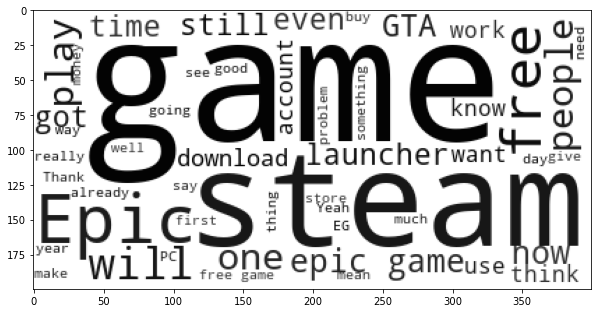

In [15]:
stp = STOPWORDS.copy()
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

- ### __Vader and Textblob__

Vader package first

In [16]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

#FIRST, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


We can add sentiment scores to words manually if we want

In [17]:
new_words = {
    'hello': -1000,
}

sid.lexicon.update(new_words)

In [18]:
sid.polarity_scores('hello there')

{'neg': 0.999, 'neu': 0.001, 'pos': 0.0, 'compound': -1.0}

In [19]:
#As this is for demonstration purposes only - instead of doing the scoring over 200,000+ rows, we will use a subset
df = comments[comments.Key<101]
df.shape

(8004, 4)

In [20]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

d:\sentiment-analysis\venv\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
df[['neg','neu','pos','compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

d:\sentiment-analysis\venv\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [22]:
df.head(3)

,Reply,Upvote,Time,Key,neg,neu,pos,compound
0,"I just did my first purchase from epic , I got...",25.0,2020-05-22 12:37:51,1.0,0.140,0.860,0.000,-0.4168
1,Actually i already bought 3 games on epic : Th...,8.0,2020-05-22 12:45:06,1.0,0.185,0.736,0.079,-0.6369
2,me who got the 80th game for free : ),7.0,2020-05-22 14:11:36,1.0,0.000,0.680,0.320,0.5106


Textblob package now

In [23]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [24]:
nltk.download('movie_reviews')
tba('My life is a frictionless slide downhill').sentiment

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [25]:
#As this is for demonstration purposes only - we will only use a subset
df = comments[comments.Key<101]

In [26]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

d:\sentiment-analysis\venv\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [27]:
df[['Classification','positive','negative']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

d:\sentiment-analysis\venv\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [28]:
df.head(3)

,Reply,Upvote,Time,Key,Classification,positive,negative
0,"I just did my first purchase from epic , I got...",25.0,2020-05-22 12:37:51,1.0,pos,0.742065,0.257935
1,Actually i already bought 3 games on epic : Th...,8.0,2020-05-22 12:45:06,1.0,pos,0.866839,0.133161
2,me who got the 80th game for free : ),7.0,2020-05-22 14:11:36,1.0,neg,0.497501,0.502499


In [32]:
df.describe()

,Upvote,Key,positive,negative
count,8004.000000,8004.000000,8004.000000,8.004000e+03
mean,3.739630,46.440905,0.556067,4.439334e-01
std,9.748104,27.676811,0.261323,2.613230e-01
min,-46.000000,1.000000,0.000407,6.419391e-18
25%,1.000000,23.000000,0.385964,2.454377e-01
50%,1.000000,43.000000,0.539849,4.601512e-01
75%,3.000000,71.000000,0.754562,6.140364e-01
max,217.000000,100.000000,1.000000,9.995932e-01


In [34]:
df['Classification'].value_counts()

pos    4871
neg    3133
Name: Classification, dtype: int64